# The main steps

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune the model
7. Present solution
8. Launch, monitor and maintain the system

# Working with Real Data

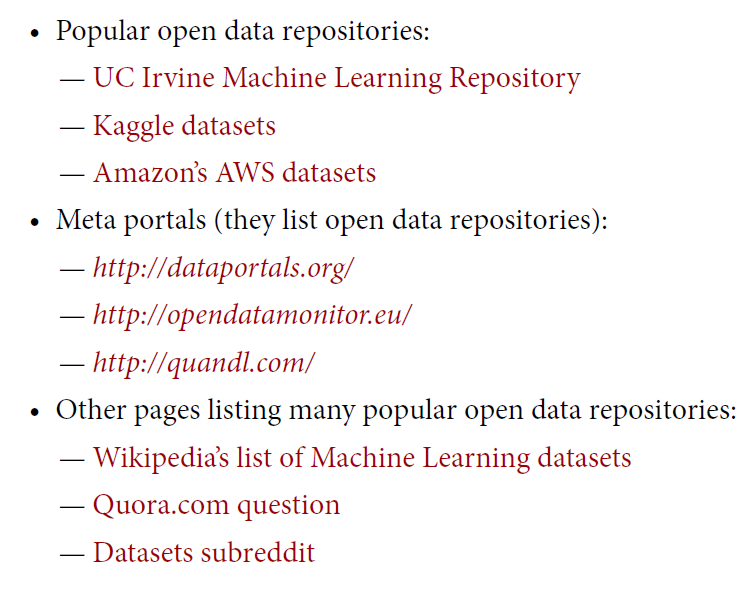

---

## Looking at the Big Picture



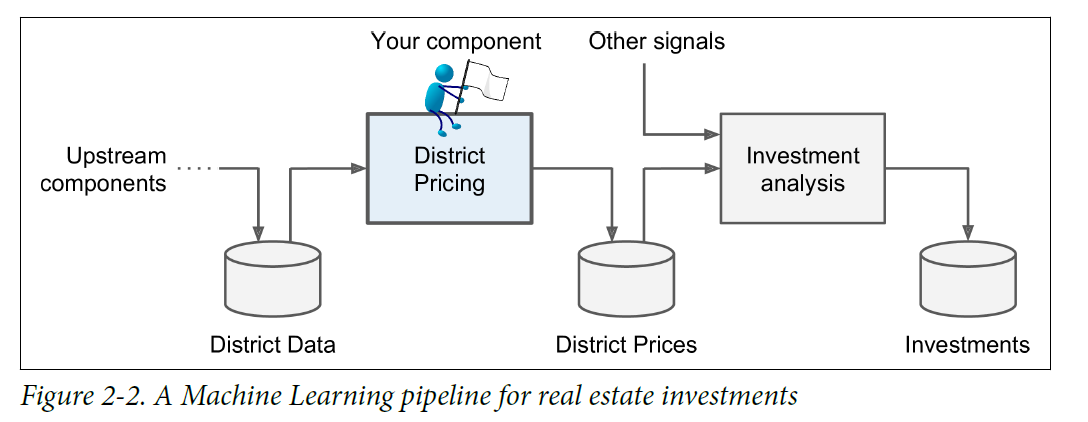


* Frame the problem

Business objective &rarr; building a model is probably not the end goal. How does the company expect to use and benefit from this model?

What the current solution looks like (if any) &rarr; reference performance, insights


* Select a Performance Measure

* Check the Assumptions
    - List and verify assumptions that were made so far

---

## Get the data

* Create the workspace &rarr; directory for the ML code and datasets

### Take a Quick Look at the Data Structure

* df.head() &rarr; check attributes
* df.info() &rarr; quick description of data &rarr; nrows, attribute's type and n_non-null values
* For categorical attributes: value_counts()
* For numerical attributes: describe() &rarr; std, max, min, quartiles,
* histograms
    * Understand how the data was computed &rarr; check for preprocessed attributes
    * Check attribute scales
    * Check heavy-tailed histograms &rarr; transform to have more bell-shaped distributions

###  Create Test Set


Even before having a more in-depth look at the data, split it. Humans are prone to overtfitting: you may find something which might cause you to use a certain algorithm (_data snooping_ bias)

* Stratified Sampling

---



## Discover and Visualize Data to gain insights

Getting a little more in depth

First, make sure the test set is put aside. Second, if the training set is too large, take a sample out of it to explore.

* While we can spot patterns on pictures, it is wise to also to mess with the visualization parameters (like alpha in a scatter plot) to make patterns stand out.

###  Looking for Correlations

Check the correlations between the attributes. For a small data set, _standard correlation coefficient_ (_Pearson's r_) might be useful 

corr_matrix = df.corr()

to check for an specific attribute: corr_matrix["attribute"].sort_values()

We can also use pandas _scatter\_matrix_ function, which plots every numerical attribute against every other numerical attribute

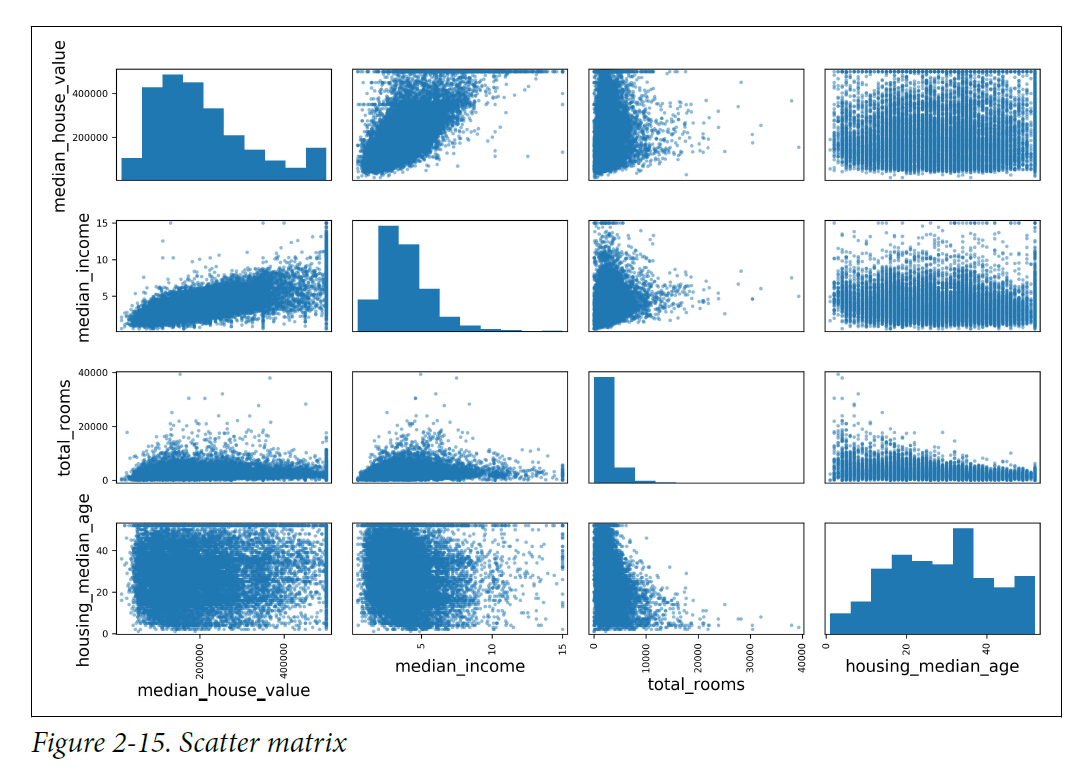

### Experimenting with Attribute Combinations

This exploration does not have to be thorough &rarr; the point is to gain insights that will help us get a reasonably good prototype. This is an iterative process.

---

## Prepare the Data for Machine Learning Algorithms

Instead of doing it manually, it is better to write functions to it:

    - Reproduce transformations easily on any dataset
    - Gradually build a library of transformation functions that can be reused in future projects
    - Makes it possible to easily try different transformations and see which combination of transformations works best
    
    

### Data Cleaning

Most Machine Learning algorithms can't work with missing features

Dealing with null values:

* Get rid of corresponding rows &rarr; dropna()
* Get rid of whole attribute &rarr; drop()
* Set the values to some value (zero, mean, median, etc) &rarr; fillna()



Scikit-Learn can also deal with filling missing values:



In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

imputer.fit(df)

The imputer has computed the median of each attribute and stored the result in its _statistics_ instance attribute
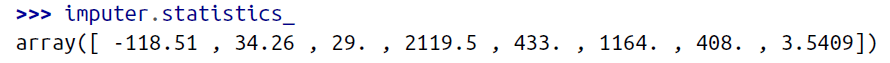

Check on book (pg 67. and beyond) to checkmore about Scikit-Learn functionality.

### Handling Text and Categorical Attributes

Most Machine Learning algorithms prefer to work with numbers &rarr; convert from text to numbers (<b>Label Encoding</b>)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

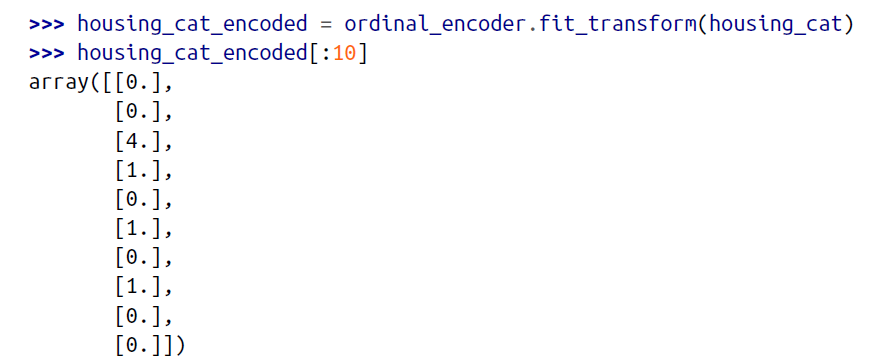


You can get the list of categories using the _categories\__ instance

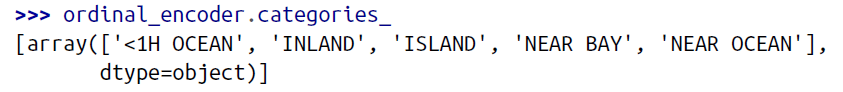

One issue with this approach is that ML algorithms will assume that closer values are more similar than distant ones. This may be good in some cases (e.g, ordered categoris: bad, average, good, excelent). To fix this issue, a common approach is to create a binary attribute between each category &rarr; <b>one-hot encoding</b>: only one attribute will be equal to 1 (hot) while the others will be equal to 0 (cold). They are also called _dummy attributes_



In [ ]:
>>> from sklearn.preprocessing import OneHotEncoder
>>> cat_encoder = OneHotEncoder()
>>> housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

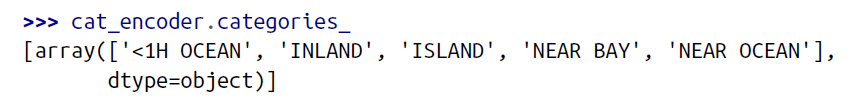

If a categorical attribute has a large number of possible categories, the one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. Some of the solutions are replacing the categorical input with numerical features related to the categories (for example, instead of small, medium, large, use the distances assigned to it)

### Custom Transformers

Although Scikit-Learn provides many useful transformers, we will need to write
our own for tasks such as custom cleanup operations or combining specific
attributes.

### Feature Scaling

Machine Learning does not perform well when the input numerical attributes have very different scales. <b>Generally, the target value does not need scaling.</b>

There are two common ways to scale the attributes: <b>_min-max scaling_</b> and <b>_standardization_</b>
    
Min-max scaling (or _normalization_) shifts and rescale the values so they end up ranging from 0 to 1. We subtract the min value and divide it by Max-Min &rarr; for ScikitLearn: _MinMaxScaler_ (can also use the hyperparameter _feature\_range_ if you on't want a 0-1 range).

Standardization is different: subtract the mean value and then divide by the standard deviation (so unit variance and zero mean). Unlike min-max scaling, standardization is not bounded to a specific range, which may be a problem for certain algorithms (neural networks expect values between 0 and 1). <b>However, standardization is much less affected by outliers</b> &rarr; for ScikitLearn: _StandardScaler_

*Obs: fit the scalers to the training data only, not the full dataset. Only then you can transform the training set and the test set (and new data).

### Transformation Pipelines

There are many data transformation steps required to be executed in the right order. ScikitLearn provides the _Pipeline_ class to help with sequences of transformation.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
    
housing_num_tr = num_pipeline.fit_transform(housing_num)

When you call the pipeline’s _fit()_ method, it calls _fit_transform()_ sequentially on
all transformers, passing the output of each call as the parameter to the next call, until
it reaches the final estimator, for which it just calls the _fit()_ method.

---

## Select and Train a Model

### 

### Training and Evaluating on the Training Set

#### Better Evaluation using Cross-Validation

Use ScikitLearn's _K-fold cross validation_ feature.


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

cross-validation feature expects a utility function (greater is better) rather than a cost function (lower is better). Since MSE is a cost function, we get the opposite of it to test.

We should save every model we experiment with, so we can come back easily to any model we want, saving both hyperparameters and the trained parameters, as well as the cross-validation scores and maybe even the predictions. You can save Scikit-Learn models by using Python's _pickle_ module, or using sklearn.externals.joblib

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

The goal is to find to shortlist a few promising models (two to five).

### Fine-Tune Your Model

Now that we have a shortlist of promising models, we need to fine-tune them.

#### Grid Search

Rather than trying manually different combinations of hyperparameters, we can use Scikit-Learn's _GridSearchCV_ to search for us. We pass the hyperparameters we want to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameters values, using cross-validation

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                    scoring='neg_mean_squared_error',
                    return_train_score=True)


grid_search.fit(housing_prepared, housing_labels)

If _GridSearchCV_ is initialized with refit = True (which is the default), then once it finds the best estimator using cross-validation, it retrains on the whole training set.

Some of the data preparation steps can also be treated as hyperparameters. For example, GridSearch will find out whether or not to add a feature we are not sure about, similarly being used to find the best way to handle outliers, missing features, feature selection, etc.



### Randomized Search

When the hyperparameter _search space_ is large, it is often preferable to use _RandomizedSearchCV_ instead. It is used the same way as _GridSearchCV_, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

### Ensemble Methods

Try to combine the models that perform best. The group ("ensemble") will often perform better than the best individual model, especially if the individual models makes very different type of errors.

### Analyze the Best Models and their Errors

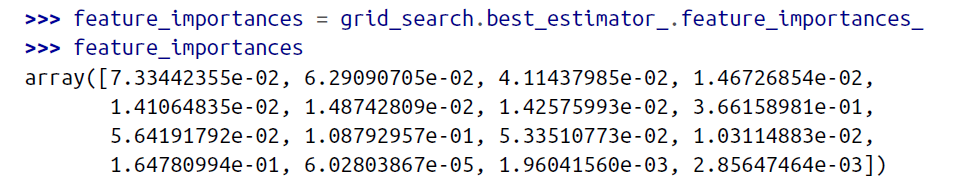

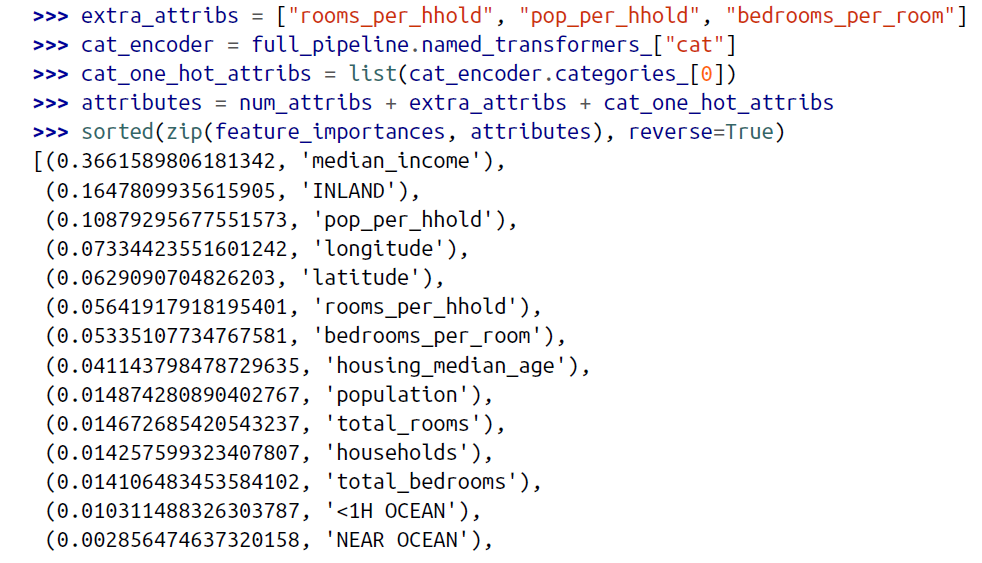


Then try some solutions, like dropping less important features, look at specific errors your system makes, etc

### Evaluate your system

After tweaking your model, it is time to evaluate the final model on the test set. Find its generalization error, and a 95% confidence interval.



---

## Present your solution

highlight what we learned, what worked and what did not, the assumptions made, system's limitations, etc

## Launch, Monitor, and Maintain Your System

* Get solution ready for production, pluggin the production input data sources into the system and writing tests.

* Monitor code to check system's live performance at regular intervals and trigger alerts when it drops &rarr; avoid breakage and performance degradation.

* Human evaluation of the system

* Evaluate input data quality

* Retrain the model on a regular basis using fresh data &rarr; automate it as much as possible)